In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

import os
import collections
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import random

2023-11-18 23:12:28.593533: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-18 23:12:28.595157: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-18 23:12:28.619798: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-18 23:12:28.619829: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-18 23:12:28.619867: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

In [2]:
rd_state = 666

In [4]:
# Load labels

Label = collections.namedtuple("Label", "id code name dir")

labels = []
reverse_labels = dict()

for id, dir in enumerate(os.listdir('images/Images/')):
    code, name = dir.split('-', 1)
    labels.append(Label(id, code, name, dir))
    reverse_labels[name] = id

NB_CLASSES = len(labels)

In [5]:
# Manually look at images
if False:  
    dirpath = 'images/Images/%s' % labels[0].dir
    f = os.listdir(dirpath)[0]
    img = mpimg.imread('%s/%s' % (dirpath, f))
    plt.imshow(img)

'Saluki'

1.0

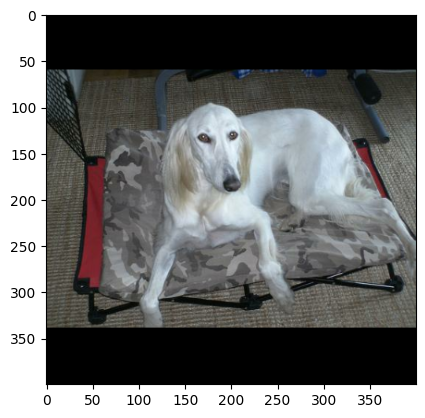

In [37]:
RESIZE_WIDTH, RESIZE_HEIGHT, CHANNELS = 400, 400, 3
SHUFFLE_SIZE = 1000
BATCH_SIZE = 32

@tf.py_function(Tout=tf.int32)
def label_to_int(lbl):
  return reverse_labels[lbl.numpy().decode('utf-8')]

def load_image(file_path):
  dir = tf.strings.split(file_path, os.sep)[-2]
  label = tf.strings.split(dir, '-', 1)[-1]
  label = label_to_int(label)
  label.set_shape(())
  img = tf.io.decode_jpeg(tf.io.read_file(file_path), channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)
  img = tf.image.resize_with_pad(img, RESIZE_WIDTH, RESIZE_HEIGHT)
  img.set_shape((RESIZE_WIDTH, RESIZE_HEIGHT, CHANNELS))
  return img, label

#list_ds = tf.data.Dataset.list_files('images/Images/*/*').shuffle(SHUFFLE_SIZE)
#TOTAL_SIZE = list_ds.cardinality().numpy()
#labeled_ds = list_ds.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

train_ds = tf.data.Dataset.list_files('data/train/*/*').shuffle(SHUFFLE_SIZE).map(load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(BATCH_SIZE)
val_ds = tf.data.Dataset.list_files('data/val/*/*').shuffle(SHUFFLE_SIZE).map(load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(BATCH_SIZE)
test_ds = tf.data.Dataset.list_files('data/test/*/*').shuffle(SHUFFLE_SIZE).map(load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(BATCH_SIZE)

for img, lbl in train_ds.take(1):
  display(labels[lbl[0].numpy()].name)
  plt.imshow(img[0])

In [7]:
TEST_SIZE, VAL_SIZE, TRAIN_SIZE = test_ds.cardinality().numpy(), val_ds.cardinality().numpy(), train_ds.cardinality().numpy()
TOTAL_SIZE = TEST_SIZE + VAL_SIZE + TRAIN_SIZE

print("Total size: %s - Train size: %s" % (TOTAL_SIZE, TRAIN_SIZE))

Total size: 644 - Train size: 545


In [7]:
# Checking that val, test and train are different

if False:
    import xxhash
    
    print("Computing fingerprints for all 3 sets")
    
    test_fingerprints = set()
    for imgs, _ in test_ds:
        for i in imgs:
            fp = xxhash.xxh128(i.numpy().tobytes())
            test_fingerprints.add(fp)
    
    print("Done computing test fingerprints")
    
    val_fingerprints = set()
    for imgs, _ in val_ds:
        for i in imgs:
            fp = xxhash.xxh128(i.numpy().tobytes())
            val_fingerprints.add(fp)
    
    print("Done computing val fingerprints")
    
    train_fingerprints = set()
    for imgs, _ in train_ds:
        for i in imgs:
            fp = xxhash.xxh128(i.numpy().tobytes())
            if fp in train_fingerprints:
                print("Duplicate: %s" % fp)
            train_fingerprints.add(fp)
    
    print("Done computing train fingerprints")
    print("")
    
    print("%s test, %s val, %s train" % (len(test_fingerprints), len(val_fingerprints), len(train_fingerprints)))
    
    print("Common train & val: %s" % len(train_fingerprints.intersection(val_fingerprints)))
    print("Common train & test: %s" % len(train_fingerprints.intersection(test_fingerprints)))
    print("Common test & val: %s" % len(test_fingerprints.intersection(val_fingerprints)))
    
    #print("Example common: %s" % test_fingerprints.intersection(val_fingerprints))

In [8]:
def label_str(label):
    return labels[label].name

for i in range(len(labels)):
    print("%s -> %s" % (i, label_str(i)))
    assert(i == reverse_labels[label_str(i)])

0 -> Great_Dane
1 -> Maltese_dog
2 -> EntleBucher
3 -> German_short-haired_pointer
4 -> Tibetan_terrier
5 -> Newfoundland
6 -> Tibetan_mastiff
7 -> bluetick
8 -> Samoyed
9 -> German_shepherd
10 -> Airedale
11 -> affenpinscher
12 -> American_Staffordshire_terrier
13 -> standard_poodle
14 -> Chihuahua
15 -> toy_terrier
16 -> Pekinese
17 -> Bedlington_terrier
18 -> golden_retriever
19 -> Siberian_husky
20 -> Border_collie
21 -> Great_Pyrenees
22 -> Old_English_sheepdog
23 -> miniature_pinscher
24 -> African_hunting_dog
25 -> miniature_poodle
26 -> Rhodesian_ridgeback
27 -> Saint_Bernard
28 -> redbone
29 -> English_setter
30 -> wire-haired_fox_terrier
31 -> pug
32 -> chow
33 -> soft-coated_wheaten_terrier
34 -> English_springer
35 -> Brabancon_griffon
36 -> giant_schnauzer
37 -> cocker_spaniel
38 -> Staffordshire_bullterrier
39 -> Bernese_mountain_dog
40 -> Sussex_spaniel
41 -> Appenzeller
42 -> bloodhound
43 -> Italian_greyhound
44 -> Rottweiler
45 -> Irish_terrier
46 -> Yorkshire_terrier

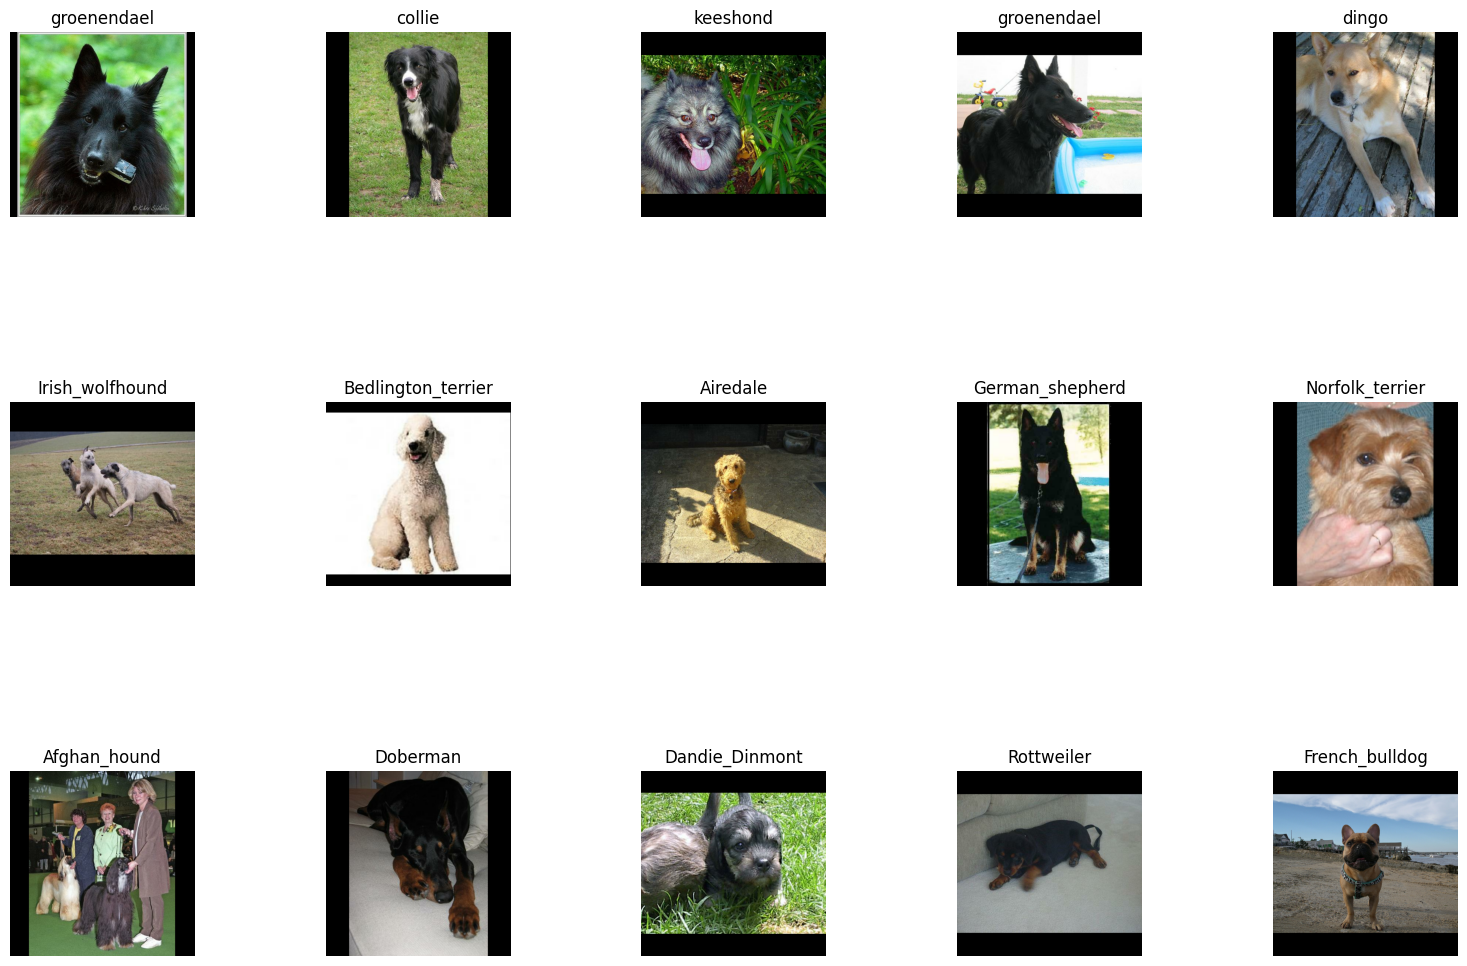

In [9]:
def show_items(inp, X, Y, label=None, labels=None, true_labels=None):
    fX = 20
    fY = int(fX*Y/X)

    figure, axis = plt.subplots(max(Y, 2), max(X, 2), figsize=(fX,fY))
    if label is not None:
        if not isinstance(label, str):
            label = label_str(label)
        figure.suptitle(label, y=0.9)
    plt.subplots_adjust(wspace=0.1, hspace=1)
    for x in range(X):
        for y in range(Y):
            axis[y, x].imshow(inp[y*X+x])
            axis[y, x].axis('off')
            if labels is not None:
                if true_labels is not None:
                    axis[y, x].set_title(label_str(labels[y*X+x]) + " != " + label_str(true_labels[y*X+x]))
                else:
                    axis[y, x].set_title(label_str(labels[y*X+x]))

# Let's peek at some random pictures
show_input = []
show_labels = []
for img, lbl in train_ds.take(1):
  for i, l in zip(img, lbl):
      show_labels.append(l)
      show_input.append(i.numpy())
show_items(show_input, 5, 3, labels=show_labels)

In [10]:
# function to plot the learning curves
def plot_results(history):
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))

    ax1.plot(history['loss'], label="Train loss")
    if 'val_loss' in history:
        ax1.plot(history['val_loss'], label="Validation loss")
    ax2.plot(history['accuracy'], label="Train accuracy")
    if 'val_accuracy' in history:
        ax2.plot(history['val_accuracy'], label="Validation accuracy")

    ax1.legend(fontsize=15);
    ax2.legend(fontsize=15);

    ax1.set_title('Loss per epoch', fontsize=25);
    ax1.set_xlabel("epoch", fontsize=20);
    ax2.set_title('Accuracy per epoch', fontsize=25);
    ax2.set_xlabel("epoch", fontsize=20);

    ax1.grid(True)
    ax2.grid(True);

In [38]:
# Model parameters

data_augmentation = True
regularization = False
#type = "stupid"
#type = "ffnn-120"
type = "ffnn-256-256"
#type = "cnn"

suffix = ""
if data_augmentation:
    suffix += "_aug"
if regularization:
    suffix += "_reg"
model_file = '%s%s_model.keras' % (type, suffix)
history_file = model_file + '.history'

all_history = collections.defaultdict(list)

In [39]:
# Train a predictor

if os.path.exists(model_file):
    raise "Safety check: the model %s already exists" % model_file

sequence = []

if data_augmentation:
    max_rotation = 0.1
    max_translation = 0.1
    max_zoom = 0.1
    max_contrast = 0.1
    
    sequence.extend([
        tf.keras.layers.RandomFlip(mode="horizontal"),
        tf.keras.layers.RandomRotation((-max_rotation, max_rotation), fill_mode="nearest", interpolation="nearest"),
        tf.keras.layers.RandomTranslation((-max_translation, max_translation), (-max_translation, max_translation), fill_mode="nearest", interpolation="nearest"),
        tf.keras.layers.RandomZoom((-max_zoom, max_zoom), fill_mode="nearest", interpolation="nearest"),
        tf.keras.layers.RandomContrast(max_contrast),
    ])
    
if type == "stupid":
    # Very stupid feed-forward network (though still pretty good)
    sequence.extend([
        tf.keras.layers.Flatten(),
    ])
elif type.startswith("ffnn"):
    # Simple feed-forward network
    layers = type.split("-")[1:]
    sequence.extend([
        tf.keras.layers.Flatten(),
    ])
    for l in layers:
        sequence.extend([
            tf.keras.layers.Dense(l, activation='relu'),
        ])
elif type == "cnn":
    noise = 0.1
    # A convolution neural network
    sequence.extend([
        tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), input_shape=[400,400,3], padding="same", activation="relu"),
        #tf.keras.layers.BatchNormalization(),
        #tf.keras.layers.ReLU(),
        tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding="valid"),
        tf.keras.layers.GaussianNoise(noise),
        tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"),
        #tf.keras.layers.BatchNormalization(),
        #tf.keras.layers.ReLU(),
        tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding="valid"),
        tf.keras.layers.GaussianNoise(noise),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation="relu"),
        #tf.keras.layers.BatchNormalization(),
        #tf.keras.layers.ReLU(),
    ])
else:
    raise "Unknown type '%s'" % type

if regularization:
    # Regularization
    sequence.extend([
        tf.keras.layers.GaussianNoise(0.1),
        tf.keras.layers.Dropout(0.2),
    ])
    
# Output
sequence.extend([
    tf.keras.layers.Dense(NB_CLASSES)
])

model = tf.keras.Sequential(sequence)

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_ds, epochs=1, validation_data=val_ds)
all_history = history.history

545/545 [==============================] - 283s 519ms/step - loss: 8.8315 - accuracy: 0.0100 - val_loss: 4.7855 - val_accuracy: 0.0172


In [12]:
# Or load last saved model
import pickle

model = tf.keras.models.load_model(model_file)
with open(history_file, 'rb') as f:
    all_history = pickle.load(f)
display(all_history)

{'loss': [229.1256866455078,
  192.94371032714844,
  182.60069274902344,
  174.71652221679688,
  163.03541564941406,
  154.7501678466797,
  147.94500732421875,
  139.2837677001953,
  136.34060668945312,
  128.23878479003906,
  127.53807067871094,
  120.77908325195312,
  118.07115936279297,
  112.300537109375,
  106.56140899658203,
  106.08183288574219,
  101.05467987060547,
  95.91661834716797,
  97.56169128417969,
  87.97998046875,
  92.9734115600586,
  85.59526824951172,
  82.33685302734375,
  80.82476043701172,
  77.61495971679688,
  80.97390747070312,
  79.57552337646484,
  72.22029113769531,
  69.06685638427734,
  67.78694915771484,
  67.40739440917969,
  68.53128814697266,
  68.9806900024414],
 'accuracy': [0.017677782103419304,
  0.04178385064005852,
  0.06657866388559341,
  0.08339551091194153,
  0.10882167518138885,
  0.12931182980537415,
  0.15829651057720184,
  0.17878666520118713,
  0.20163002610206604,
  0.22722837328910828,
  0.24134764075279236,
  0.26619985699653625,
  

In [ ]:
import pickle
import time

ITERS = 5
for i in range(ITERS):
    #if i > 0:
    #    time.sleep(100)
    if i > 0 and i%5 == 0:
        print("%s/%s iterations" % (i, ITERS))
    this_history = model.fit(train_ds, epochs=1, validation_data=val_ds)
    for k in this_history.history:
        all_history[k].extend(this_history.history[k])
    model.save(model_file)
    with open(history_file, 'wb') as f:
        pickle.dump(all_history, f)

116/545 [=====>........................] - ETA: 4:10 - loss: 4.7786 - accuracy: 0.0108

'Model summary:'

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, 400, 400, 3)       0         
                                                                 
 random_rotation (RandomRot  (None, 400, 400, 3)       0         
 ation)                                                          
                                                                 
 random_translation (Random  (None, 400, 400, 3)       0         
 Translation)                                                    
                                                                 
 random_zoom (RandomZoom)    (None, 400, 400, 3)       0         
                                                                 
 random_contrast (RandomCon  (None, 400, 400, 3)       0         
 trast)                                                          
                                                      

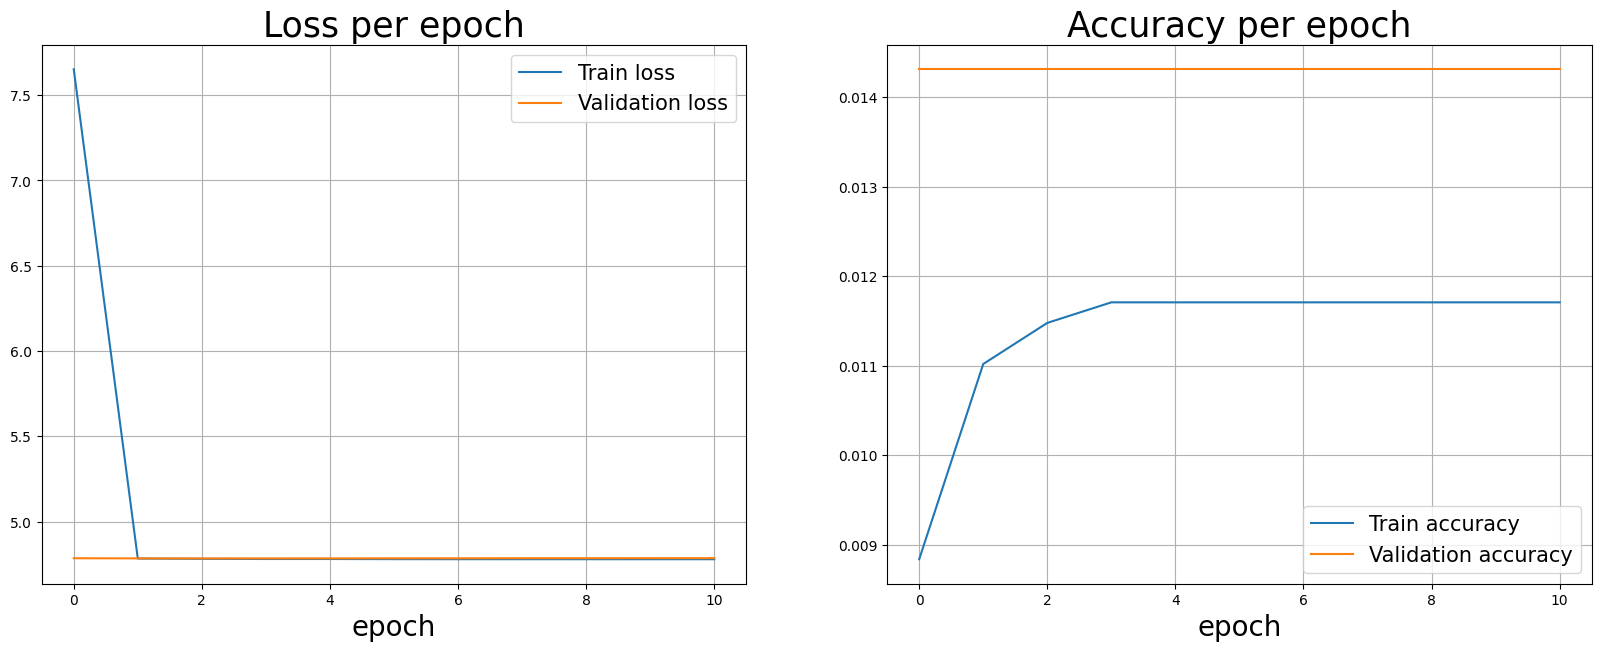

In [34]:
display("Model summary:")
model.summary()

test_loss, test_acc = model.evaluate(test_ds, verbose=2)

print('\nTest accuracy:', test_acc)

plot_results(all_history)

In [16]:
#for img, lbl in labeled_ds.shuffle(SHUFFLE_SIZE).batch(BATCH_SIZE).take(1):
to_show_imgs = []
to_show_predicted = []
to_show_true_label = []
all_predicted = []
all_true_labels = []
true_predicted_count = np.zeros((NB_CLASSES, NB_CLASSES))
errors = 0
total = 0
for img, lbl in test_ds:
    try:
        inp = tf.reshape(img, (BATCH_SIZE, 400, 400, 3))
        result = np.argmax(model.predict(inp), axis=1)
        for (i, l, r) in zip(img, lbl, result):
            total += 1
            all_predicted.append(r)
            all_true_labels.append(l)
            true_predicted_count[l][r] += 1
            if l != r:
                errors += 1
                to_show_imgs.append(i)
                to_show_predicted.append(r)
                to_show_true_label.append(l)
    except:
        # Ignore the last batch which will not be of size 32
        pass

print("%s bad predictions out of %s (accuracy = %.2f%%)" % (errors, total, 100*(total-errors)/total))

1/1 [==============================] - 0s 32ms/step
2015 bad predictions out of 2080 (accuracy = 3.12%)


In [17]:
import math

avg_precision = 0
avg_recall = 0
details = pd.DataFrame(columns=['id', 'precision','recall'], index=[label_str(x) for x in range(NB_CLASSES)])

for l in range(NB_CLASSES):
    precision = recall = 0
    if sum(true_predicted_count[:,l]) != 0:
        precision = 100*true_predicted_count[l][l]/sum(true_predicted_count[:,l])
    if sum(true_predicted_count[l]) != 0:
        recall = 100*true_predicted_count[l][l]/sum(true_predicted_count[l])
    details.loc[label_str(l)] = pd.Series({'id': l, 'precision': precision, 'recall': recall})
    avg_precision += precision
    avg_recall += recall
    
avg_precision /= NB_CLASSES
avg_recall /= NB_CLASSES

print("")
print("Avg precision = %.2f%%, Avg recall = %.2f%%" % (avg_precision, avg_recall))
print("")

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(details)


Avg precision = 5.24%, Avg recall = 3.07%



id  precision     recall
Great_Dane                        0.0   6.060606  11.764706
Maltese_dog                       1.0   7.407407       6.25
EntleBucher                       2.0  16.666667       10.0
German_short-haired_pointer       3.0        0.0        0.0
Tibetan_terrier                   4.0        0.0        0.0
Newfoundland                      5.0        0.0        0.0
Tibetan_mastiff                   6.0        0.0        0.0
bluetick                          7.0        0.0        0.0
Samoyed                           8.0        0.0        0.0
German_shepherd                   9.0   2.083333   7.142857
Airedale                         10.0   2.222222  23.529412
affenpinscher                    11.0        0.0        0.0
American_Staffordshire_terrier   12.0        0.0        0.0
standard_poodle                  13.0        0.0        0.0
Chihuahua                        14.0        0.0        0.0
toy_terrier                      15.0        0.0        0.0
Pekinese                         16.0        0.0        0.0
Bedlington_terrier               17.0        0.0        0.0
golden_retriever                 18.0   2.325581   4.761905
Siberian_husky                   19.0        0.0        0.0
Border_collie                    20.0   6.153846       25.0
Great_Pyrenees                   21.0        0.0        0.0
Old_English_sheepdog             22.0   3.333333   5.882353
miniature_pinscher               23.0        0.0        0.0
African_hunting_dog              24.0      100.0       6.25
miniature_poodle                 25.0        0.0        0.0
Rhodesian_ridgeback              26.0        0.0        0.0
Saint_Bernard                    27.0        0.0        0.0
redbone                          28.0        0.0        0.0
English_setter                   29.0        0.0        0.0
wire-haired_fox_terrier          30.0   1.041667   7.692308
pug                              31.0        0.0        0.0
chow                             32.0        0.0        0.0
soft-coated_wheaten_terrier      33.0       40.0  16.666667
English_springer                 34.0   1.111111  26.315789
Brabancon_griffon                35.0        0.0        0.0
giant_schnauzer                  36.0      100.0   5.882353
cocker_spaniel                   37.0        0.0        0.0
Staffordshire_bullterrier        38.0        0.0        0.0
Bernese_mountain_dog             39.0        0.0        0.0
Sussex_spaniel                   40.0       10.0   5.555556
Appenzeller                      41.0        0.0        0.0
bloodhound                       42.0       50.0   4.545455
Italian_greyhound                43.0        0.0        0.0
Rottweiler                       44.0        0.0        0.0
Irish_terrier                    45.0        0.0        0.0
Yorkshire_terrier                46.0        0.0        0.0
schipperke                       47.0        0.0        0.0
Blenheim_spaniel                 48.0        0.0        0.0
silky_terrier                    49.0       25.0   5.555556
Labrador_retriever               50.0        0.0        0.0
Norwich_terrier                  51.0        0.0        0.0
Lakeland_terrier                 52.0        0.0        0.0
boxer                            53.0   0.952381   5.555556
miniature_schnauzer              54.0        0.0        0.0
Shetland_sheepdog                55.0       50.0   5.555556
black-and-tan_coonhound          56.0        0.0        0.0
beagle                           57.0        0.0        0.0
Irish_wolfhound                  58.0   3.030303   4.761905
Cardigan                         59.0        0.0        0.0
toy_poodle                       60.0        0.0        0.0
West_Highland_white_terrier      61.0        0.0        0.0
basset                           62.0        0.0        0.0
kuvasz                           63.0        0.0        0.0
vizsla                           64.0        0.0        0.0
Leonberg                         65.0       20.0   4.347826
Chesapeake_Bay_

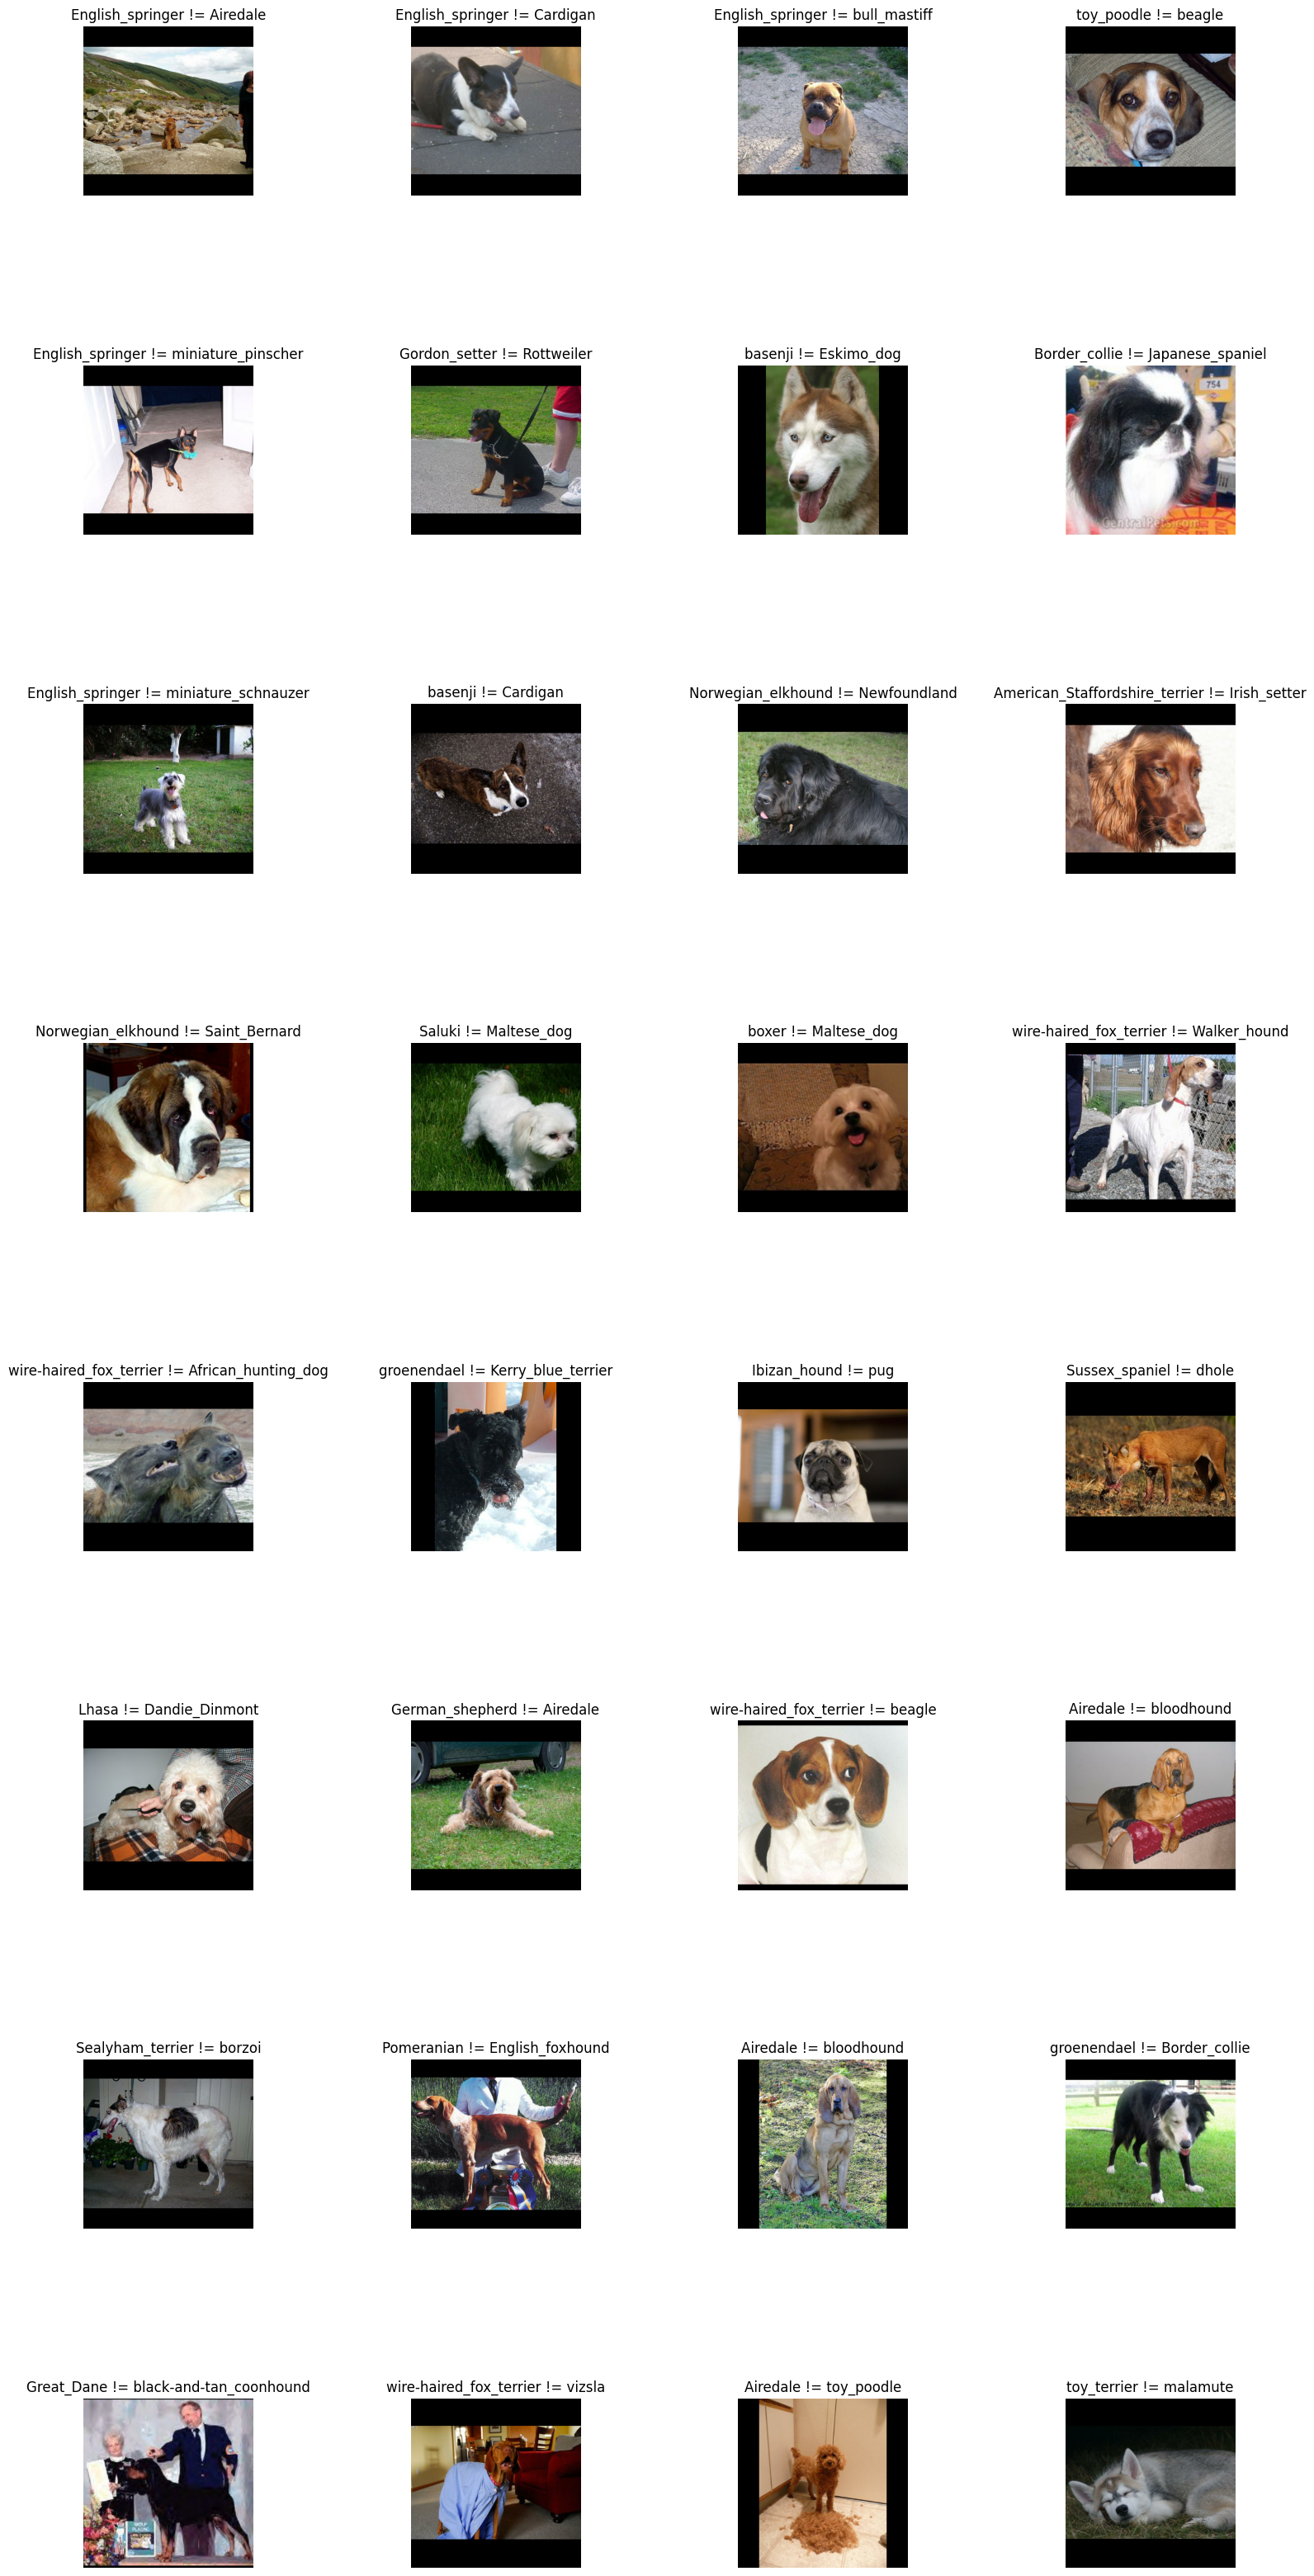

In [18]:
show_items(to_show_imgs, 4, 8, labels=to_show_predicted, true_labels=to_show_true_label)

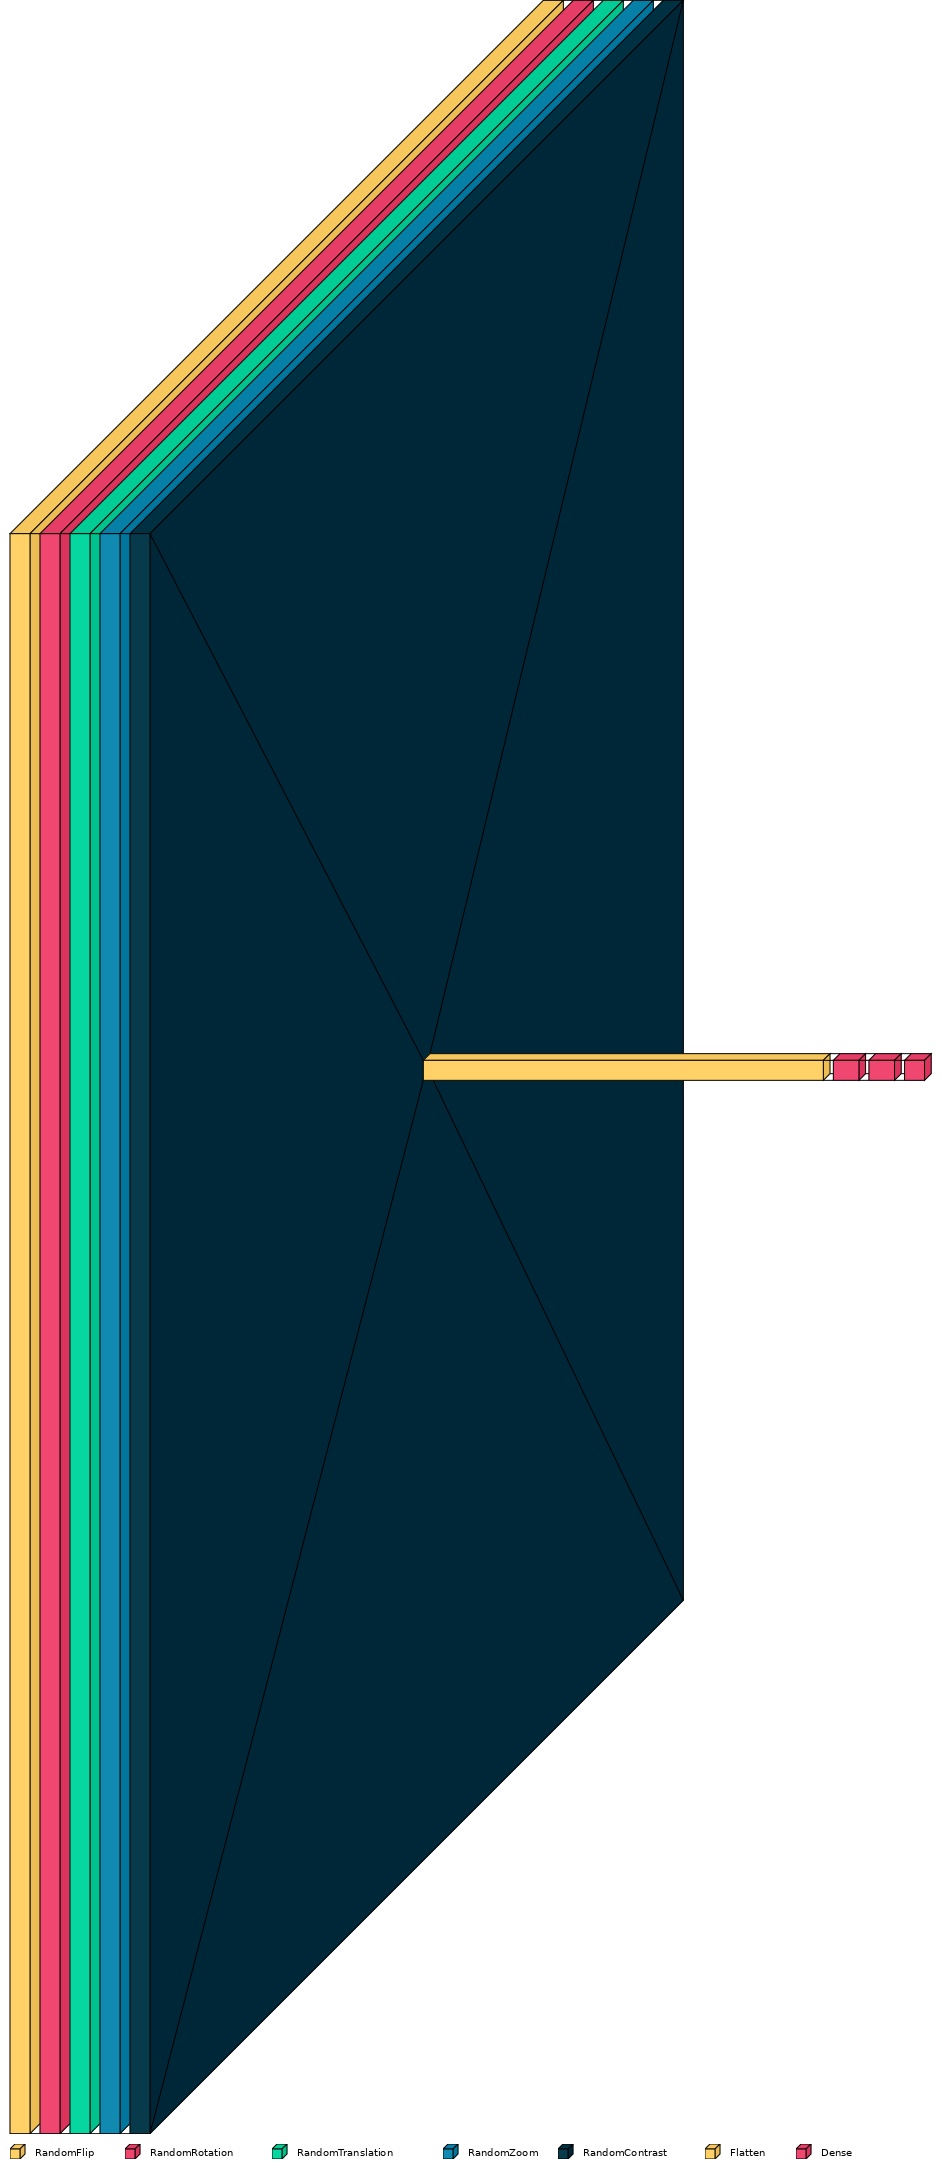

In [41]:
import visualkeras
from PIL import ImageFont

font = ImageFont.truetype("/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf", 10, encoding="unic")
# A hack to make the legend work because getsize has been removed from Pillow but visualkeras wasn't updated:
# https://github.com/tensorflow/models/issues/11040
font.getsize = lambda str: [8*len(str), 10]

visualkeras.layered_view(model, legend=True, font=font).convert('RGB')

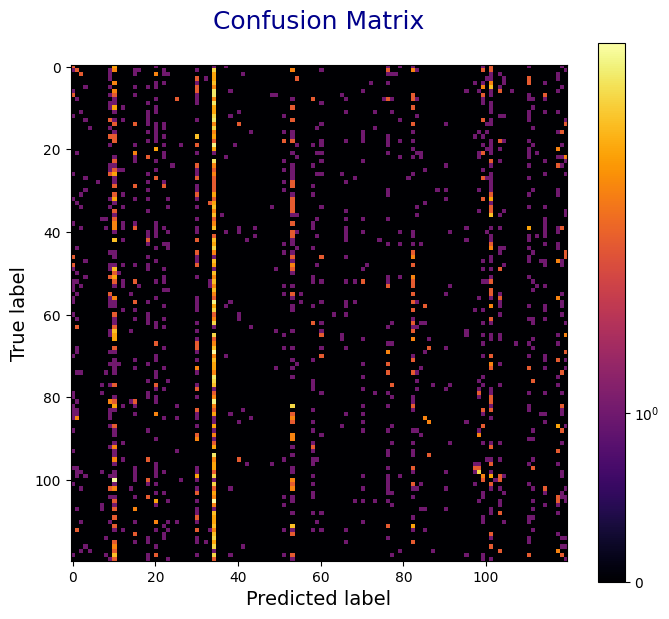

In [20]:
def plot_confusion_matrix(real, predictions, names):
    raw_confusion = tf.math.confusion_matrix(real, predictions)
    # Remove the diagonal
    #confusion = confusion - np.diag(np.diag(confusion))
    
    confusion = pd.DataFrame(
        data=raw_confusion,
        index=names,
        columns=names,
    )
    #display(confusion)
    plt.figure(figsize = (8,7), facecolor='white')
    plt.title('Confusion Matrix\n', fontsize = 18, color = 'darkblue')
    plt.ylabel('True label', fontsize = 14)
    plt.xlabel('Predicted label', fontsize = 14)
    #plt.xticks(range(NB_CLASSES), labels, size='small')
    #plt.yticks(range(NB_CLASSES), labels, size='small')
    plt.imshow(confusion, cmap='inferno', norm='symlog')
    #for y, row in enumerate(raw_confusion):
    #    for x, v in enumerate(row):
    #        color = 'white' if v.numpy() < 100 else 'black'
    #        plt.text(x, y, v.numpy(), color=color, horizontalalignment='center', verticalalignment='center')
    plt.colorbar(ticks=[0, 1, 10, 100, 1000])
    plt.show()

plot_confusion_matrix(all_true_labels, all_predicted, labels)